In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
import matplotlib.pyplot as plt

class AdvancedRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1, dropout_rate=0.2, use_batch_norm=True):
        super(AdvancedRegressionModel, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Première couche
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        if use_batch_norm:
            self.layers.append(nn.BatchNorm1d(hidden_dims[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_rate))
        
        # Couches cachées
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            if use_batch_norm:
                self.layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
        
        # Dernière couche
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Initialisation des poids
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, nn.BatchNorm1d) and x.dim() == 3:
                x = layer(x.transpose(1, 2)).transpose(1, 2)
            else:
                x = layer(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.2, use_batch_norm=True):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim) if use_batch_norm else nn.Identity()
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return self.relu(out)

class ResidualRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks, output_dim=1, dropout_rate=0.2, use_batch_norm=True):
        super(ResidualRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim, dropout_rate, use_batch_norm) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

In [16]:
def train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100):
    best_loss = np.inf
    epochs_no_improve = 0
    loss_save = []
    r2_save = {}
    best_r2 = float('-inf')
    epochs_no_improve_r2 = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(features_train_tensor)
        loss = criterion(y_pred, target_train_tensor)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(features_test_tensor)
            val_loss = criterion(y_val_pred, target_test_tensor)
            # Calcul du R² sur l'ensemble de validation
            r2_val = 1 - val_loss / torch.var(target_test_tensor)
            r2_train = 1 - loss / torch.var(target_train_tensor)

        # Vérifier si le R² de validation s'est amélioré de 0.01
        if torch.abs(r2_val - best_r2) > 0.01:
            best_r2 = r2_val
            epochs_no_improve_r2 = 0
            print(f'Epoch {epoch + 1}, Improved R²: {best_r2.item()}')
        else:
            epochs_no_improve_r2 += 1
            if epochs_no_improve_r2 == patience:
                print(f'Early stopping! Epoch {epoch + 1}, Best R²: {best_r2.item()}')
                break  # Arrêt anticipé

        # Optionnel: Enregistrer la perte d'entraînement pour visualisation
        loss_save.append(loss.item())
        r2_save[epoch] = {'train_loss': loss.item(), 'val_loss': val_loss.item(), 'r2': r2_val.item(),
                            'train_r2': r2_train.item()}

    # Visualisation de la perte d'entraînement
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax.plot(loss_save, label='Training Loss', color='blue')
    ax.plot([x['val_loss'] for x in r2_save.values()], label='Validation Loss', color='red')
    #log scale y axis
    ax.set_yscale('log')
    ax.set_title('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax2.plot([x['r2'] for x in r2_save.values()], label='R² test', color='green')
    ax2.plot([x['train_r2'] for x in r2_save.values()], label='R² train', color='blue')
    ax2.legend()
    ax2.set_title('R² Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R²')
    #ax2 between 0 and 1
    ax2.set_ylim(0, 1)
    plt.show()

    return model

In [9]:
# Générer des données de régression synthétiques
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
#norm X and y 
X = X / np.max(X, axis=0)
y = y / np.max(y)

In [10]:

# Séparer les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Convertir les données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



# Exemple d'utilisation
# model = AdvancedRegressionModel(input_dim=10, hidden_dims=[64, 32, 16], dropout_rate=0.3, use_batch_norm=True)
# model_residual = ResidualRegressionModel(input_dim=10, hidden_dim=64, num_blocks=3, dropout_rate=0.3, use_batch_norm=True)

In [28]:
# Créer un modèle de régression avancé
model = AdvancedRegressionModel(input_dim=20, hidden_dims=[64], output_dim=1, dropout_rate=0.2, use_batch_norm=True)
# Définir la fonction de perte et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Improved R²: -52.427955627441406
Epoch 2, Improved R²: -55.24750518798828
Epoch 3, Improved R²: -58.23167037963867
Epoch 4, Improved R²: -61.395145416259766
Epoch 5, Improved R²: -64.73319244384766
Epoch 6, Improved R²: -68.18602752685547
Epoch 7, Improved R²: -71.79281616210938
Epoch 8, Improved R²: -75.52790069580078
Epoch 9, Improved R²: -79.38712310791016
Epoch 10, Improved R²: -83.38459777832031
Epoch 11, Improved R²: -87.50624084472656
Epoch 12, Improved R²: -91.71517181396484
Epoch 13, Improved R²: -96.0054931640625
Epoch 14, Improved R²: -100.35819244384766
Epoch 15, Improved R²: -104.75286102294922
Epoch 16, Improved R²: -109.183837890625
Epoch 17, Improved R²: -113.60655212402344
Epoch 18, Improved R²: -117.97247314453125
Epoch 19, Improved R²: -122.27257537841797
Epoch 20, Improved R²: -126.49125671386719
Epoch 21, Improved R²: -130.64749145507812
Epoch 22, Improved R²: -134.65907287597656
Epoch 23, Improved R²: -138.38421630859375
Epoch 24, Improved R²: -141.860412

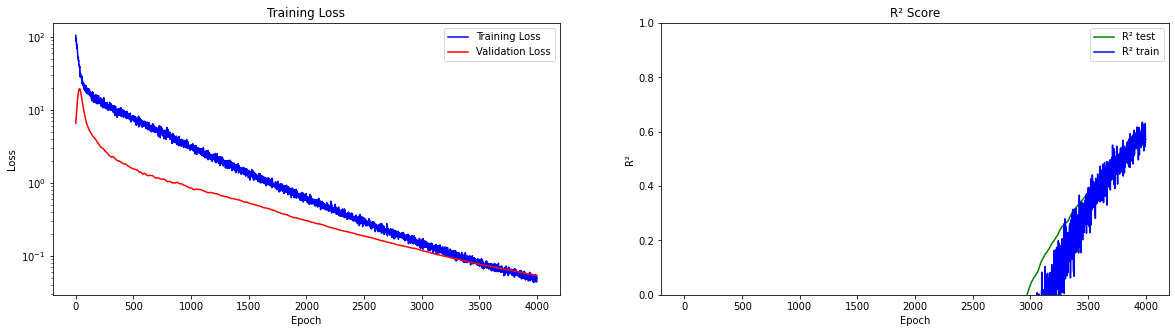

In [29]:
# Entraîner le modèle
model = train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, n_epochs=4000, patience=100)
        

In [30]:
# create a model residual
model_residual = ResidualRegressionModel(input_dim=20, hidden_dim=64, num_blocks=3, dropout_rate=0.2, use_batch_norm=True)
# Définir la fonction de perte et l'optimiseur
criterion_residual = nn.MSELoss()
optimizer_residual = optim.Adam(model_residual.parameters(), lr=0.001)

Epoch 1, Improved R²: -0.3594716787338257
Epoch 2, Improved R²: -0.3056771755218506
Epoch 3, Improved R²: -0.26011669635772705
Epoch 4, Improved R²: -0.2200711965560913
Epoch 5, Improved R²: -0.18712902069091797
Epoch 6, Improved R²: -0.16030752658843994
Epoch 7, Improved R²: -0.1412128210067749
Epoch 8, Improved R²: -0.1295151710510254
Epoch 10, Improved R²: -0.11244606971740723
Epoch 12, Improved R²: -0.09554445743560791
Epoch 13, Improved R²: -0.08149981498718262
Epoch 14, Improved R²: -0.06464183330535889
Epoch 15, Improved R²: -0.04348611831665039
Epoch 16, Improved R²: -0.018586158752441406
Epoch 17, Improved R²: 0.006621360778808594
Epoch 18, Improved R²: 0.03482961654663086
Epoch 19, Improved R²: 0.060995399951934814
Epoch 20, Improved R²: 0.0917513370513916
Epoch 21, Improved R²: 0.12444108724594116
Epoch 22, Improved R²: 0.16273683309555054
Epoch 23, Improved R²: 0.20477598905563354
Epoch 24, Improved R²: 0.2479202151298523
Epoch 25, Improved R²: 0.29369407892227173
Epoch 26,

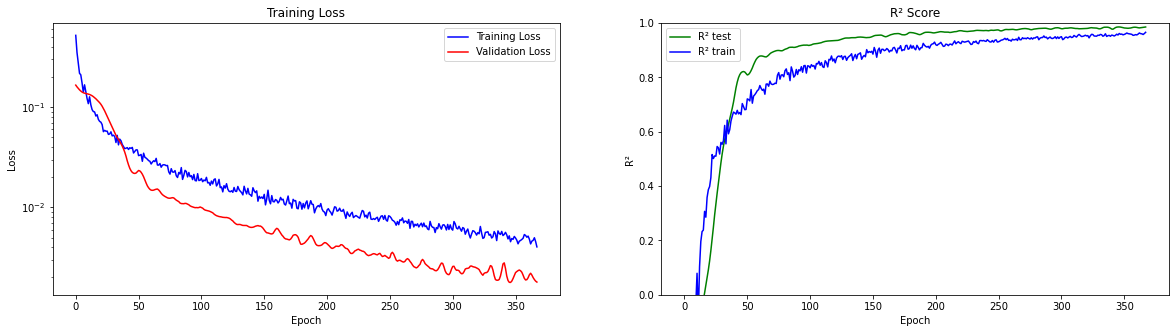

In [31]:
#train the model
model_residual = train_model(model_residual, optimizer_residual, criterion_residual, X_train, y_train, X_val, y_val, n_epochs=4000, patience=100)
